In [6]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "svg"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

In [10]:
from main import SpatialGroups
from multiprocessing import Pool
import pandas as pd

In [8]:
model = SpatialGroups(strengthLambda=0.1, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

  0%|          | 0/10001 [00:00<?, ?it/s]

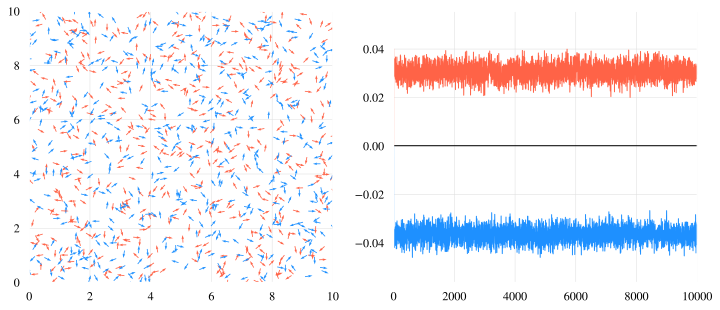

In [14]:
targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

# upLim, lowLim = totalPhaseTheta.mean(axis=1).max(), totalPhaseTheta.mean(axis=1).min()
# upLim, lowLim = np.pi, -np.pi
upLim, lowLim = totalPointTheta.max(), totalPointTheta.min()
class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

# TNum = 50
pbar = tqdm(total=TNum)

def plot_frame(i):
    if model.tqdm:
        pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    fig.clear()
    ax1 = plt.subplot(1, 2, 1)
    line = ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    line = ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    # ax2.plot(np.mean(totalPhaseTheta[:i, class1], axis=1), color='tomato', linewidth=1)
    # ax2.plot(np.mean(totalPhaseTheta[:i, class2], axis=1), color='dodgerblue', linewidth=1)
    ax2.plot(totalPointTheta[:i, class1][:, 0], color='tomato', linewidth=1)
    ax2.plot(totalPointTheta[:i, class2][:, 0], color='dodgerblue', linewidth=1)
    ax2.plot(np.mean(totalPointTheta[:i], axis=1), color='black', linewidth=1)
    ax2.set_xlim(0, TNum)
    ax2.set_ylim(lowLim, upLim)

    return line

fig, ax = plt.subplots(figsize=(12, 5))
ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum), interval=50, repeat=False)
ani.save(f"{model}_pointTheta.mp4", dpi=200)

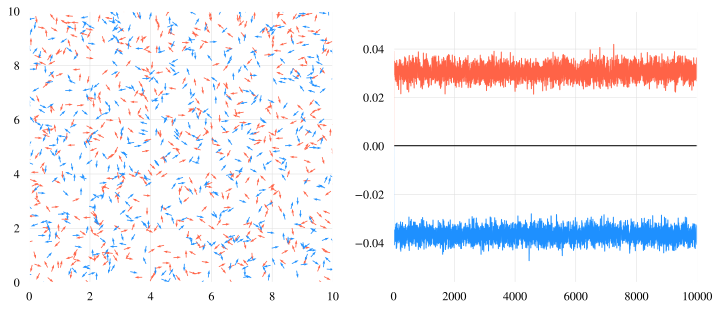

In [33]:
model = SpatialGroups(strengthLambda=0.09, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

fig, ax = plt.subplots(figsize=(12, 5))
plot_frame(TNum-1)

In [10]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

In [11]:
def run_model(model):
    model.run(50000)

In [12]:
with Pool(19) as p:
    p.map(run_model, models)

In [4]:
!whereis bypy

bypy: /home/thanmark/.local/bin/bypy


In [ ]:
!ec4a44ca78572df5e1dcb9c0f4d7b21b

In [ ]:
model.run_mp4(TNum=50)